In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "060824"

library(readxl)
library(openxlsx)
library(tidyverse)
library(gtsummary)
library(ordinalNet)
library(reshape2)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpubr)

# reading in file
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_BP_Subjects_060724.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score
,<chr>,<chr>,<dbl>
1,Cortisol,CS_M_21_W_5,0.24743096
2,Cortisol,CS_M_24_W_8,0.31083055
3,Cortisol,CS_M_25_W_10,0.13144609
4,Cortisol,CS_M_28_W_16,0.06754252
5,Cortisol,CS_M_29_W_17,0.44649218
6,Cortisol,CS_F_31_B_21,0.21687581


In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

Starting by combining the dataframes.

In [3]:
# creating a vector for variables that increase atherosclerotic risk
# HDL decreases risk
allostatic_load_biomarkers = c('Cortisol','Noradrenaline','Epinephrine','Hba1c','Fibrinogen','CRP', 'HDL')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining allostatic load biomarkers only
        filter(Variable %in% allostatic_load_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:14,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(mediator_scores_df)

head(reg_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.24743096,0.9209663,0.06894884,0.23783025,0.017763222,0.29358611,0.09415997,N
CS_M_24_W_8,0.31083055,0.5018144,0.29255348,0.05082129,0.008710668,0.23290254,0.08473086,N
CS_M_25_W_10,0.13144609,0.8466564,0.64414592,0.26137633,0.060818954,0.02491066,0.36245167,E
CS_M_28_W_16,0.06754252,0.5018144,0.11121726,0.00000000,0.026508784,0.17484827,1.00000000,N
CS_M_29_W_17,0.44649218,0.3297612,0.28738359,0.18107212,0.016648117,0.52779975,0.72404411,N
CS_F_31_B_21,0.21687581,0.2711344,0.75504241,0.16931582,0.129876982,0.06673031,0.31548045,N


# Assessing Distributions

Looking at the distributions of blood pressure classifications and the mediator scores for each variable.

In [4]:
table(reg_df$BP_Classification)


 1  2  E  N 
 6  1  9 18 

The stage 1 and stage 2 classes are on the smaller side with 6 and 1 subject, respectively. There weren't enough observation of the stage 2 class to perform SMOTE; therefore, the blood pressure classes will be condensed in two different ways:

+ **3 classes**: Normal subjects, at risk (elevated) subjects, and hypertensive subjects (formerly stage 1 and stage 2 subjects)
+ **2 classes**: Normal subjects and hypertensive subjects (formerly elevated, stage 1, and stage 2 subjects)

In [5]:
three_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2"), "H", BP_Classification))

two_reg_df = reg_df %>%
    mutate(BP_Classification = ifelse(BP_Classification %in% c("1", "2", "E"), "H", BP_Classification))

# turning BP into a factor
three_reg_df$BP_Classification = factor(three_reg_df$BP_Classification, levels = c("N", "E", "H"))
two_reg_df$BP_Classification = factor(two_reg_df$BP_Classification, levels = c("N", "H"))

In [6]:
table(two_reg_df$BP_Classification)
table(three_reg_df$BP_Classification)


 N  H 
18 16 


 N  E  H 
18  9  7 

Now assessing normality of the biomarkers using a shapiro wilk test.

In [7]:
# using a shapiro wilk test to assess normality
do.call(rbind.data.frame, apply(reg_df[,2:8], 2, shapiro.test))[,1:3] %>%
    # adding a column that clarifies whether or not a variable is normally distributed or not
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.7429965,2.411103e-06,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9351777,4.436357e-02,Shapiro-Wilk normality test,Non-normal
Hba1c,0.9603241,2.484953e-01,Shapiro-Wilk normality test,Normal
Fibrinogen,0.8901584,2.546482e-03,Shapiro-Wilk normality test,Non-normal
CRP,0.6714903,1.848939e-07,Shapiro-Wilk normality test,Non-normal
HDL,0.8326592,1.173812e-04,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9324863,3.697532e-02,Shapiro-Wilk normality test,Non-normal


The only variable that is normally distributed is Hba1c. Therefore, we'll perform a data transformation (pseudo log 2) to see if that helps.

In [8]:
pslog2_df = reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(pslog2_df)

Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CS_M_21_W_5,0.31895997,0.9418322,0.09619281,0.30781349,0.02540196,0.37137609,0.1298237,N
CS_M_24_W_8,0.39048120,0.5867065,0.37022397,0.07151733,0.01251242,0.30205876,0.1173371,N
CS_M_25_W_10,0.17816785,0.8849155,0.71733834,0.33499877,0.08517846,0.03549816,0.4462051,E
CS_M_28_W_16,0.09429353,0.5867065,0.15214092,0.00000000,0.03774597,0.23247445,1.0000000,N
CS_M_29_W_17,0.53255852,0.4111672,0.36444198,0.24009707,0.02382042,0.61145546,0.7857967,N
CS_F_31_B_21,0.28318193,0.3461165,0.81150589,0.22566464,0.17616570,0.09319548,0.3955898,N


In [9]:
do.call(rbind.data.frame, apply(pslog2_df[,2:8], 2, shapiro.test))[,1:3] %>%
    mutate(Normality = ifelse(p.value < 0.05, "Non-normal", "Normal"))

,statistic,p.value,method,Normality
,<dbl>,<dbl>,<chr>,<chr>
Cortisol,0.8291083,9.879115e-05,Shapiro-Wilk normality test,Non-normal
Noradrenaline,0.9530450,1.514515e-01,Shapiro-Wilk normality test,Normal
Hba1c,0.9695032,4.479052e-01,Shapiro-Wilk normality test,Normal
Fibrinogen,0.9404895,6.375442e-02,Shapiro-Wilk normality test,Normal
CRP,0.7209469,1.048238e-06,Shapiro-Wilk normality test,Non-normal
HDL,0.9079889,7.507847e-03,Shapiro-Wilk normality test,Non-normal
Epinephrine,0.9437510,7.978057e-02,Shapiro-Wilk normality test,Normal


Now we have 4 out of 7 variables that are normally distributed.

In [10]:
# need to use the pslog2 data
three_reg_df = three_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

two_reg_df = two_reg_df %>%
    mutate(across(Cortisol:Epinephrine, ~ log2(.x + 1)))

head(three_reg_df)

Subject_ID,Cortisol,Noradrenaline,Hba1c,Fibrinogen,CRP,HDL,Epinephrine,BP_Classification
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
CS_M_21_W_5,0.31895997,0.9418322,0.09619281,0.30781349,0.02540196,0.37137609,0.1298237,N
CS_M_24_W_8,0.39048120,0.5867065,0.37022397,0.07151733,0.01251242,0.30205876,0.1173371,N
CS_M_25_W_10,0.17816785,0.8849155,0.71733834,0.33499877,0.08517846,0.03549816,0.4462051,E
CS_M_28_W_16,0.09429353,0.5867065,0.15214092,0.00000000,0.03774597,0.23247445,1.0000000,N
CS_M_29_W_17,0.53255852,0.4111672,0.36444198,0.24009707,0.02382042,0.61145546,0.7857967,N
CS_F_31_B_21,0.28318193,0.3461165,0.81150589,0.22566464,0.17616570,0.09319548,0.3955898,N


# Summary Statistics

Determining if there are any significant differences between the features for each outcome class.

In [24]:
# 3 class outcome
inner_join(three_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:8]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "aov",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`
Warning for variable 'Smoking_Status':
simpleWarning in stats::chisq.test(x = c("CS", "CS", "CS", "CS", "CS", "CS", "CS", : Chi-squared approximation may be incorrect

Warning for variable 'Sex':
simpleWarning in stats::chisq.test(x = c("M", "M", "M", "M", "M", "F", "M", "M", : Chi-squared approximation may be incorrect

Warning for variable 'Race':
simpleWarning in stats::chisq.test(x = c("W", "W", "W", "W", "W", "B", "W", "B", : Chi-squared approximation may be incorrect



**Characteristic**,**N**,"**N**, N = 18","**E**, N = 9","**H**, N = 7",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.29 (0.23),0.17 (0.11),0.27 (0.27),0.4
Noradrenaline,34,0.49 (0.32),0.47 (0.24),0.40 (0.34),0.8
Hba1c,34,0.43 (0.26),0.66 (0.17),0.45 (0.22),0.055
Fibrinogen,34,0.38 (0.26),0.33 (0.21),0.31 (0.15),0.8
CRP,34,0.15 (0.25),0.20 (0.24),0.35 (0.38),0.3
HDL,34,0.36 (0.23),0.26 (0.11),0.21 (0.15),0.2
Epinephrine,34,0.49 (0.27),0.39 (0.22),0.30 (0.25),0.2
Smoking_Status,34,NA,NA,NA,0.9
CS,NA,9 (50%),5 (56%),3 (43%),NA


In [25]:
# two class outcome
inner_join(two_reg_df, subject_info_df[,c(3,5:8)]) %>%

    tbl_summary(by = BP_Classification, missing = "no", 
    include = c(colnames(three_reg_df[2:8]), colnames(subject_info_df[5:8])), 
              statistic = list(all_continuous() ~ "{mean} ({sd})",
                               all_categorical() ~ "{n} ({p}%)")) %>%
    add_n() %>% 
    #add_overall() %>%
    add_p(test = list(all_continuous() ~ "t.test",
                    all_categorical() ~ "chisq.test")) %>% # adding p value from anova
    as_tibble()

Joining with `by = join_by(Subject_ID)`


**Characteristic**,**N**,"**N**, N = 18","**H**, N = 16",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Cortisol,34,0.29 (0.23),0.21 (0.20),0.3
Noradrenaline,34,0.49 (0.32),0.44 (0.28),0.6
Hba1c,34,0.43 (0.26),0.57 (0.21),0.090
Fibrinogen,34,0.38 (0.26),0.33 (0.18),0.5
CRP,34,0.15 (0.25),0.26 (0.31),0.3
HDL,34,0.36 (0.23),0.24 (0.13),0.058
Epinephrine,34,0.49 (0.27),0.35 (0.23),0.11
Smoking_Status,34,NA,NA,>0.9
CS,NA,9 (50%),8 (50%),NA


# Ordinal Regression

Using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

In [11]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) or negative (FALSE), only HDL will be negative
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2

    # HDL needs to be negative so we'll make all the values negative
    dataset$HDL = dataset$HDL * -1
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
three_weights_df = estimateOrdWeights(three_reg_df, 'BP_Classification', biomarker_coefficients)
two_weights_df = estimateOrdWeights(two_reg_df, 'BP_Classification', biomarker_coefficients)

three_weights_df
two_weights_df

Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.54497132
Fibrinogen,0.22245325
Noradrenaline,0.17338610
Cortisol,0.05918933
Hba1c,0.00000000
CRP,0.00000000
HDL,0.00000000


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.48824252
Cortisol,0.25656179
Fibrinogen,0.18343214
Noradrenaline,0.07176355
Hba1c,0.00000000
CRP,0.00000000
HDL,0.00000000


## Ordinal Weights Visualization

In [12]:
# creating 1 df
weights_df = cbind(rbind(three_weights_df, two_weights_df), 
                   # adding a col that specificies the number of classes of blood pressure
                   Blood_Pressure_Class_No = c(rep(3, length(three_weights_df$Variable)), 
                                               rep(2, length(three_weights_df$Variable)))) %>% 
    # getting the circle positions for the text labels
    group_by(Blood_Pressure_Class_No) %>%
    mutate(csum = rev(cumsum(rev(Coefficient))), 
         pos = Coefficient/2 + lead(csum, 1),
         pos = if_else(is.na(pos), Coefficient/2, pos))

head(weights_df)

Variable,Coefficient,Blood_Pressure_Class_No,csum,pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Epinephrine,0.54497132,3,1.00000000,0.72751434
Fibrinogen,0.22245325,3,0.45502868,0.34380206
Noradrenaline,0.17338610,3,0.23257543,0.14588238
Cortisol,0.05918933,3,0.05918933,0.02959467
Hba1c,0.00000000,3,0.00000000,0.00000000
CRP,0.00000000,3,0.00000000,0.00000000


In [13]:
options(repr.plot.width=10, repr.plot.height=10) #changing size

piechart3 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 3), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 3), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 3 Blood Pressure Classes") + 
  scale_fill_npg()

col_palette = pal_npg()(7)
piechart2 = ggplot(data = weights_df %>%
       filter(Blood_Pressure_Class_No == 2), aes(x = "", y = Coefficient, fill = fct_inorder(Variable)))+
  geom_bar(width = 1, color = 1, stat = "identity") +
  coord_polar(theta = "y") + 
  # removing labels for biomarkers that = 0
  geom_label_repel(data = weights_df %>%
                  filter(Coefficient > 0 & Blood_Pressure_Class_No == 2), 
                  aes(x = 1, y = pos, label = paste0(Variable,"\n", round(Coefficient * 100), "%")), 
                   size = 5, nudge_x = 0.7, show.legend = FALSE) + 

  theme_void() +
  theme(legend.position = "none") + 
  ggtitle("Ordinal Weights with 2 Blood Pressure Classes") + 
  scale_fill_manual(values = col_palette[c(1,4,2,3,5,5,5)])

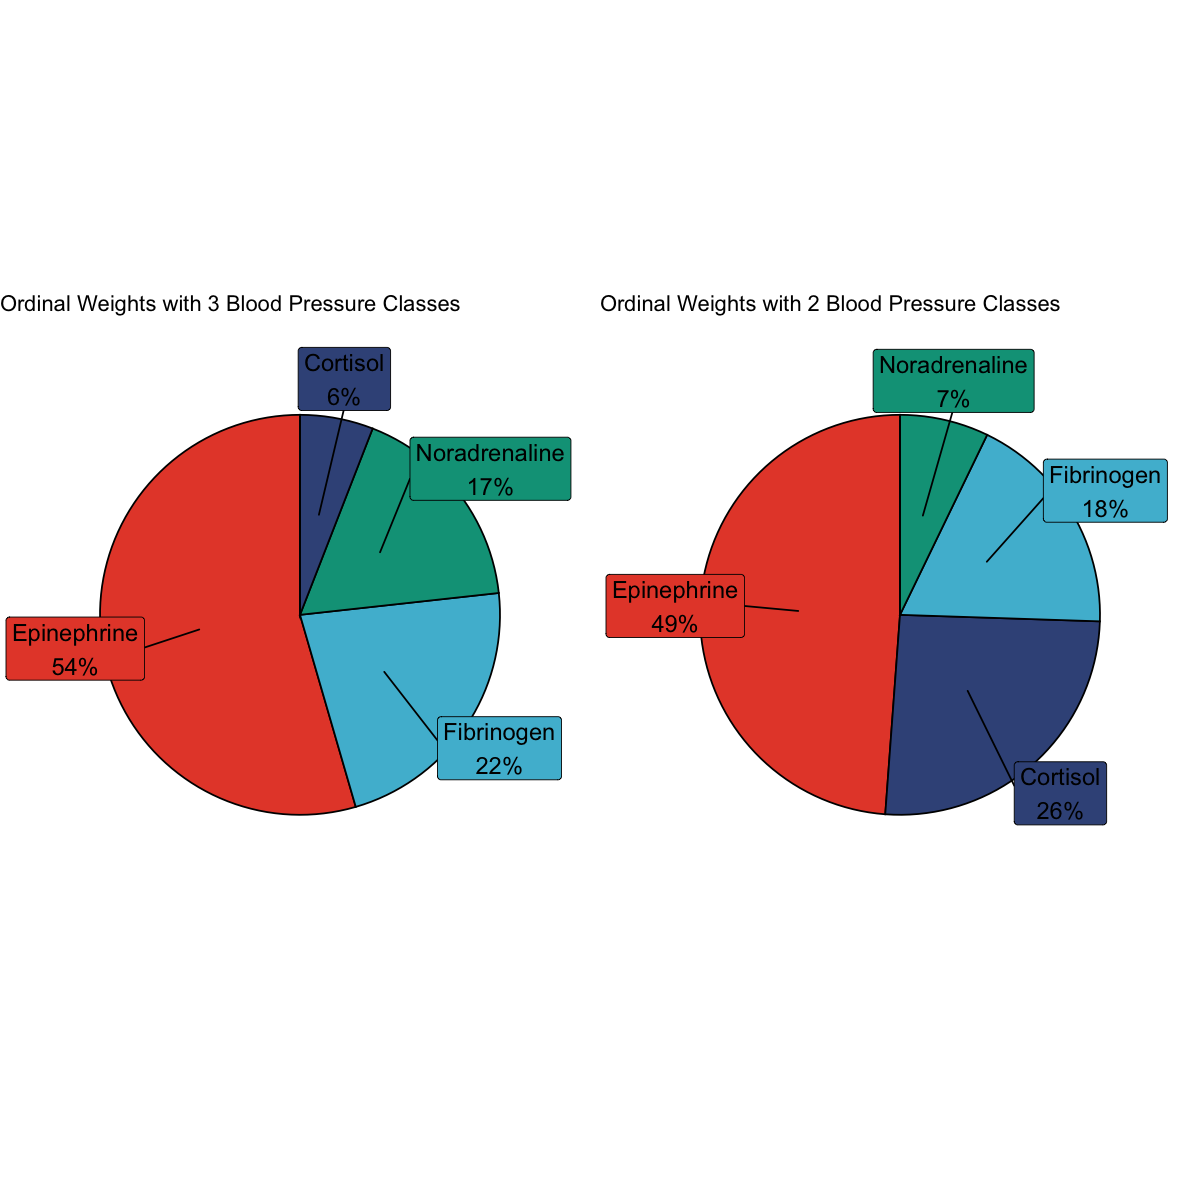

In [14]:
plot_grid(piechart3, piechart2)

Based on these results, epinephrine had the largest contribution to blood pressure classification in both cases. The same 4 biomarkers had contributions in both cases, while 3 were muted having no impact on BP classification (Hba1c, HDL, and CRP). 

# Allostatic Load Summation

Now that we have these weights from the ordinal regression, we'll calculate allostatic load scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 7 allostatic load biomarkers (cortisol, noradrenaline, epinephrine, HDL, Hba1c, fibrinogen, and CRP). The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + CRP ordinal weight * CRP score...

In [15]:
allostatic_load = function(weights_df){
    # add words!!
    
    # combining the mediator scores with the ordinal weights into one dataframe
    wider_weights_df = pivot_longer(pslog2_df[,1:8], cols = 2:8, names_to = "Variable") %>%
        dcast(Variable ~ Subject_ID, value.var = "value") %>% 
        inner_join(weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Allostatic_Load = apply(multiplication_df, 2, sum)) %>%
        arrange(-Allostatic_Load) %>%
        rownames_to_column(var = "Subject_ID")
    
    return(allostatic_load_df)
    }

# calling fn
three_allostatic_df = allostatic_load(three_weights_df)
two_allostatic_df = allostatic_load(two_weights_df)

head(three_allostatic_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Subject_ID,Allostatic_Load
,<chr>,<dbl>
1,NS_F_23_W_41,0.7073836
2,NS_F_27_B_50,0.6920901
3,NS_F_38_B_61,0.6656172
4,CS_M_28_W_16,0.6522792
5,NS_F_21_W_38,0.6209406
6,NS_F_21_B_37,0.6070839


Now testing for statistical differences based on sex and smoking status using a two way anova.

In [16]:
# adding in demographic info for each subject
three_anova_df = inner_join(three_allostatic_df, subject_info_df[,c(3,5,6,8)])
two_anova_df = inner_join(two_allostatic_df, subject_info_df[,c(3,5,6,8)])
head(three_anova_df)

# looking at counts for each variable
table(three_anova_df[,c(3,5)])

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


,Subject_ID,Allostatic_Load,Smoking_Status,Sex,Race
,<chr>,<dbl>,<chr>,<chr>,<chr>
1,NS_F_23_W_41,0.7073836,NS,F,W
2,NS_F_27_B_50,0.6920901,NS,F,B
3,NS_F_38_B_61,0.6656172,NS,F,B
4,CS_M_28_W_16,0.6522792,CS,M,W
5,NS_F_21_W_38,0.6209406,NS,F,W
6,NS_F_21_B_37,0.6070839,NS,F,B


              Race
Smoking_Status  B  W
            CS  8  9
            NS 11  6

In [17]:
# anova
three_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = three_anova_df)
three_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = three_anova_df)
three_anova_sex_race = aov(Allostatic_Load ~ Sex * Race, data = three_anova_df)
two_anova_smoking_race = aov(Allostatic_Load ~ Smoking_Status * Race, data = two_anova_df)
two_anova_smoking_sex = aov(Allostatic_Load ~ Smoking_Status * Sex, data = two_anova_df)
two_anova_sex_race = aov(Allostatic_Load ~ Sex * Race, data = two_anova_df)

summary(three_anova_smoking_race) 
summary(three_anova_smoking_sex)
summary(three_anova_sex_race)
summary(two_anova_smoking_sex)
summary(two_anova_smoking_race)
summary(two_anova_sex_race)

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.0912 0.09125   3.321 0.0784 .
Race                 1 0.0039 0.00393   0.143 0.7078  
Smoking_Status:Race  1 0.0410 0.04105   1.494 0.2311  
Residuals           30 0.8244 0.02748                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.0912 0.09125   3.465 0.0725 .
Sex                 1 0.0340 0.03396   1.290 0.2651  
Smoking_Status:Sex  1 0.0454 0.04537   1.723 0.1993  
Residuals          30 0.7900 0.02633                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq Mean Sq F value Pr(>F)
Sex          1 0.0036 0.00356   0.117  0.734
Race         1 0.0002 0.00016   0.005  0.942
Sex:Race     1 0.0453 0.04525   1.489  0.232
Residuals   30 0.9116 0.03039               

                   Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status      1 0.1214 0.12136   4.856 0.0354 *
Sex                 1 0.0133 0.01327   0.531 0.4719  
Smoking_Status:Sex  1 0.0327 0.03266   1.307 0.2620  
Residuals          30 0.7498 0.02499                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df Sum Sq Mean Sq F value Pr(>F)  
Smoking_Status       1 0.1214 0.12136   4.756 0.0372 *
Race                 1 0.0040 0.00402   0.158 0.6942  
Smoking_Status:Race  1 0.0261 0.02613   1.024 0.3196  
Residuals           30 0.7655 0.02552                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df Sum Sq  Mean Sq F value Pr(>F)
Sex          1 0.0005 0.000467   0.016  0.901
Race         1 0.0001 0.000068   0.002  0.962
Sex:Race     1 0.0316 0.031586   1.071  0.309
Residuals   30 0.8849 0.029497               

There are statistically significant differences in allostatic load based on smoking status (p value = 0.04). These significant differences were present only when using ordinal weights from blood pressure classification with two classes and were more muted with using the weights derived from prediction of 3 classes. 

There were no significant differences between sex or race and allostatic load nor was the interaction between smoking status and sex or race significant.

In [18]:
# post hoc
#TukeyHSD(anova)

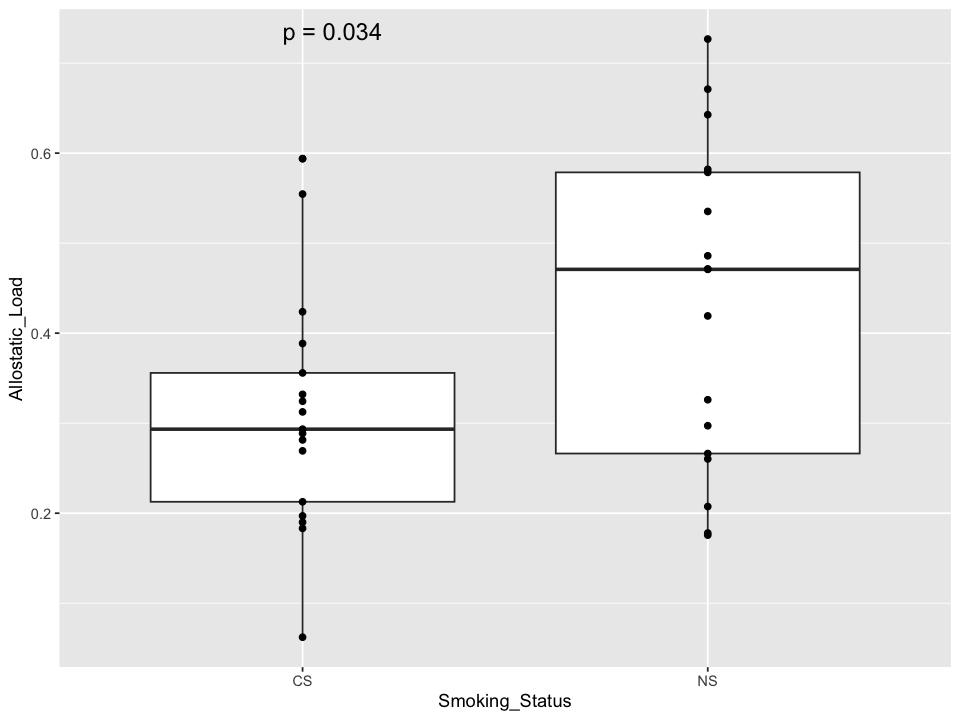

In [19]:
# visualizing using boxplots
options(repr.plot.width=8, repr.plot.height=6) #changing size

ggplot(data = two_anova_df, aes(y = Allostatic_Load, x = Smoking_Status)) + 
  geom_boxplot() +
  geom_point() + 

 stat_anova_test(wid = "Smoking_Status", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 5)

But why do NS have a higher allostatic load???